# Using CLIPSeg with Hugging Face Transformers

Using Hugging Face Transformers, you can easily download and run a pre-trained CLIPSeg model on your images. Let’s start by installing transformers.

In [ ]:
!pip install -q transformers

To download the model, simply instantiate it.

In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

# Using CLIPSeg to pre-label images on Segments.ai

As you can see, the results from CLIPSeg are a little fuzzy and very low-res. If we want to obtain better results, you can fine-tune a state-of-the-art segmentation model, as explained in [our previous blogpost](https://huggingface.co/blog/fine-tune-segformer). To finetune the model, we'll need labeled data. In this section, we'll show you how you can use CLIPSeg to create some rough segmentation masks and then refine them on [Segments.ai](https://segments.ai/?utm_source=hf&utm_medium=colab&utm_campaign=clipseg), the best labeling platform for image segmentation.  

First, create an account at [https://segments.ai/join](https://segments.ai/join?utm_source=hf&utm_medium=colab&utm_campaign=clipseg) and install the Segments Python SDK. Then you can initialize the Segments.ai Python client using an API key. This key can be found on [the account page](https://segments.ai/account).

In [ ]:
!pip install -q segments-ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 5.1 MB/s eta 0:00:00


In [ ]:
from segments import SegmentsClient
from getpass import getpass

api_key = getpass('Enter your API key: ')
segments_client = SegmentsClient(api_key)

Enter your API key: ··········


Next, let's load an image from a dataset using the Segments client. We'll use the [a2d2 self-driving dataset](https://www.a2d2.audi/a2d2/en.html). You can also create your own dataset by following [these instructions](https://docs.segments.ai/tutorials/getting-started).

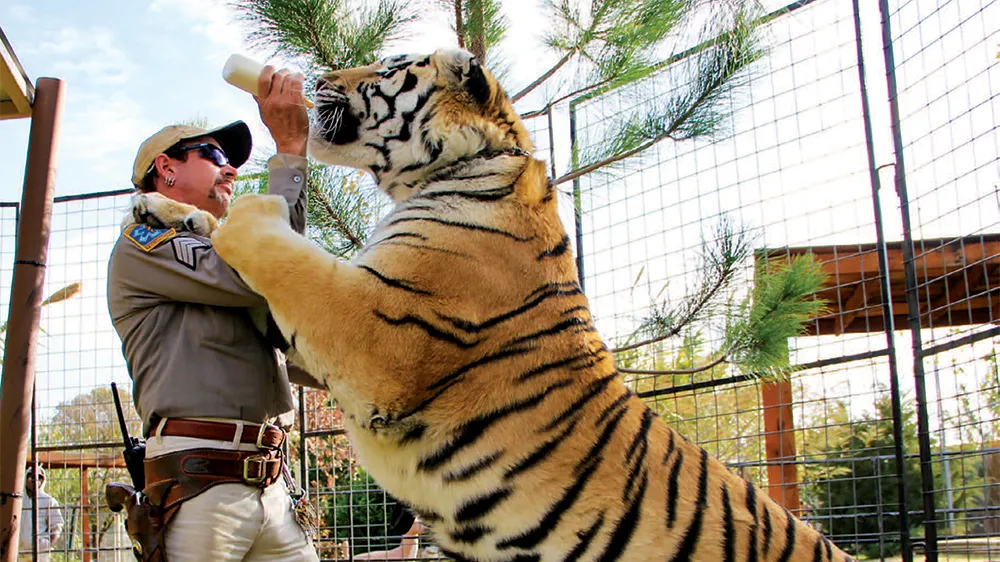

In [ ]:
samples = segments_client.get_samples("aashish/Tiger-Person")

# Use the last image as an example
sample = samples[0]
image = Image.open(requests.get(sample.attributes.image.url, stream=True).raw)
image

We also need to get the category names from the dataset attributes.

In [ ]:
dataset = segments_client.get_dataset("aashish/Tiger-Person")
category_names = [category.name for category in dataset.task_attributes.categories]

Now we can use CLIPSeg on the image as before. This time, we'll also scale up the outputs so that they match the input image's size.

In [ ]:
import torch
from torch import nn

inputs = processor(text=category_names, images=[image] * len(category_names), padding="max_length", return_tensors="pt")

# predict
with torch.no_grad():
  outputs = model(**inputs)

# resize the outputs
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(1),
    size=(image.size[1], image.size[0]),
    mode="bilinear"
)

Unused or unrecognized kwargs: padding.


And we can visualize the results again.

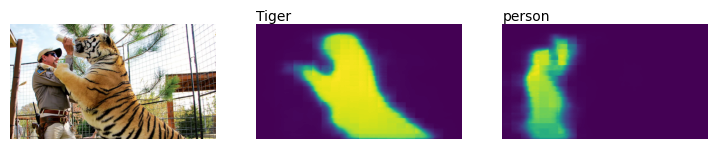

In [ ]:
import matplotlib.pyplot as plt


len_cats = len(category_names)
_, ax = plt.subplots(1, len_cats + 1, figsize=(3*(len_cats + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len_cats)];
[ax[i+1].text(0, -15, category_name) for i, category_name in enumerate(category_names)];

Now we have to combine the predictions to a single segmentated image. We'll simply do this by taking the category with the greatest sigmoid value for each patch. We'll also make sure that all the values under a certain threshold do not count.

In [ ]:
threshold = 0.2

flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

Let's quickly visualize the result.

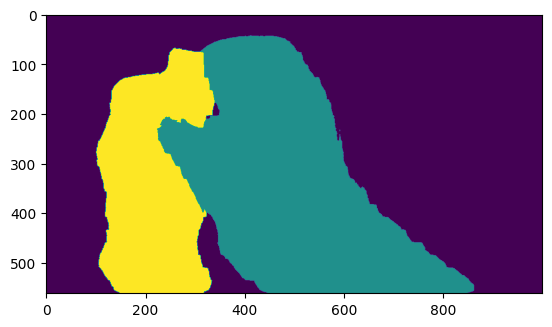

In [ ]:
plt.imshow(inds)

Lastly, we can upload the prediction to Segments.ai. To do that, we'll first convert the bitmap to a png file, then we'll upload this file to the Segments, and finally we'll add the label to the sample.

In [ ]:
from segments.utils import bitmap2file
import numpy as np
import cv2
inds_np = inds.numpy().astype(np.uint32)
unique_inds = np.unique(inds_np).tolist()
f = bitmap2file(inds_np, is_segmentation_bitmap=True)

asset = segments_client.upload_asset(f, "clipseg_prediction.png")
attributes = {
      'format_version': '0.1',
      'annotations': [{"id": i, "category_id": i} for i in unique_inds if i != 0],
      'segmentation_bitmap': { 'url': asset.url },
  }

segments_client.add_label(sample.uuid, 'ground-truth', attributes)

Label(sample_uuid='a02c6d37-1d75-4803-a9fa-d2ab26bb4cc1', label_type='segmentation-bitmap', label_status='PRELABELED', labelset='ground-truth', attributes=ImageSegmentationLabelAttributes(annotations=[Annotation(id=1, category_id=1, attributes=None), Annotation(id=2, category_id=2, attributes=None)], segmentation_bitmap=URL(url='https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/aashish/338f2f1c-ece8-4365-bbc5-1b8bebbeded7.png'), image_attributes=None, format_version='0.1'), created_at='2024-05-18T12:11:03.908177Z', created_by='aashish', updated_at='2024-05-18T12:11:03.932941Z', score=None, rating=None, reviewed_at=None, reviewed_by=None)

If you take a look at the [uploaded prediction on Segments.ai](https://segments.ai/admin-tobias/clipseg/samples/71a80d39-8cf3-4768-a097-e81e0b677517/ground-truth), you can see that it's not perfect. However, you can manually correct the biggest mistakes, and then you can use the corrected dataset to train a better model than CLIPSeg.